<a href="https://colab.research.google.com/github/yingzhuC/weread2notion/blob/main/7460_Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

In the pharmaceutical industry, accurate demand forecasting is crucial for ensuring medicine availability, optimizing inventory, and improving patient outcomes. This project focuses on forecasting the monthly sales of bronchodilator drugs (classified as R03 under the ATC system) using time series data from 2014 to 2019. Bronchodilators are commonly prescribed for chronic respiratory conditions such as asthma and chronic bronchitis, which show strong seasonal variation in patient symptoms and medication use.

Prior research has demonstrated a clear pattern of increased bronchodilator demand in colder months. For example, Cohen et al. (2014) observed a 2.28-fold rise in prescriptions during September in Israel, coinciding with seasonal asthma flare-ups in children. Such seasonal surges create significant challenges for supply chain coordination and underscore the importance of robust forecasting systems.

The aim of this project is to evaluate and compare four forecasting models to determine which provides the most accurate and actionable results for pharmaceutical planning. These models include Exponential Smoothing (ETS), Time Series Regression, a Long Short-Term Memory (LSTM) neural network, and an Ensemble model that averages the outputs of the first three. The results are assessed using standard forecasting metrics including RMSE, MAE, MAPE, and R².

This study draws upon methods established in the forecasting literature. ETS is supported by studies such as Etu et al. (2022), which found it effective for near-term predictions in healthcare. LSTM and ensemble approaches have been applied successfully in other health-related forecasting problems (e.g., Borges & Nascimento, 2022), demonstrating their potential to capture non-linear patterns and improve accuracy.

### Literature Review

Recent research in both pharmaceutical demand and healthcare operations has emphasized the need for accurate and timely forecasting models. In a large-scale population study, Cohen et al. (2014) highlighted the seasonal nature of bronchodilator use, particularly among pediatric asthma patients. These findings confirm that forecasting demand for R03 drugs requires models that can handle both trend and seasonal components effectively.

Several methods have been proposed and validated in the healthcare forecasting literature. Etu et al. (2022) compared classical statistical and deep learning models to predict hospital emergency department arrivals. Their findings showed that Exponential Smoothing (ETS) was effective for short-term forecasting and often outperformed more complex models under constrained data conditions. This supports the use of ETS as a baseline model in this project.

To address non-linear and complex patterns, deep learning models like LSTM have gained popularity. Borges and Nascimento (2022) demonstrated that a hybrid Prophet-LSTM model could outperform single-method models in forecasting ICU bed demand during COVID-19. Their results showed that combining statistical and machine learning methods enhanced both accuracy and robustness. This supports the inclusion of both LSTM and ensemble modeling in this project.

Despite the growing adoption of neural forecasting techniques, many studies have not fully compared traditional and modern models side-by-side in the pharmaceutical context. This project addresses that gap by evaluating four forecasting models using real-world sales data for bronchodilators and assessing their relative performance in terms of accuracy and interpretability.

In [2]:
# Import all necessary libraries after kernel restart
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Time series modeling
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Load the dataset
file_path = "/content/salesmonthly.csv"
df = pd.read_csv(file_path)

# Preview the data
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [4]:
# Focus on the 'R03' category and ensure it's a monthly time series
r03_series = df['R03'].copy()
r03_series.index.freq = 'MS'  # Set Monthly Start frequency

### Data Preparation

This project adopts a data-driven forecasting approach to model and predict monthly sales of bronchodilator drugs (R03 category) in the pharmaceutical sector. The dataset used spans from January 2014 to October 2019 and contains 70 monthly observations. It was sourced from the publicly available Pharma Sales dataset on Kaggle (Zdravkovic, 2021). After loading the data, I handled missing values, converted the datum column to a datetime format, and set it as the index to support time-based operations. The sales series was visualized to assess its structure, revealing both strong seasonality and a steady upward trend.

The R03 category, which includes medications used to relieve bronchial obstruction, was selected due to its clinical importance and distinct temporal patterns. These drugs are commonly used in the treatment of asthma and chronic bronchitis, with usage typically increasing in colder months. This seasonal behavior makes the R03 category a compelling target for time series forecasting. Accurate predictions in this area can directly support inventory planning, supply chain decisions, and public health preparedness.

To prepare for model training, the dataset was split into training and testing sets using an 80:20 ratio. The training set consisted of the first 56 months, and the final 14 months were held out for testing. This division allowed the models to learn from historical patterns while being evaluated on future, unseen data.

Here's the link for Kaggle site:
https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data

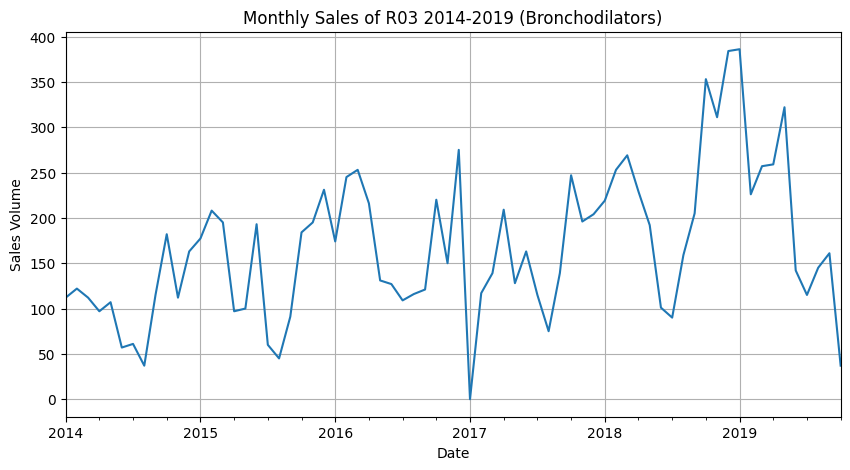

In [5]:
# Convert 'datum' to datetime and set as index
df['datum'] = pd.to_datetime(df['datum'])
df.set_index('datum', inplace=True)

# Extract R03 time series
r03 = df['R03'].copy()
r03.name = 'R03 Sales'

# Visualize the series
r03.plot(figsize=(10, 5), title="Monthly Sales of R03 2014-2019 (Bronchodilators)", ylabel="Sales Volume", xlabel="Date", grid=True)
plt.show()

### Split Data (Train = 80%, Test = 20%)

In [6]:
# Split data into training (80%) and testing (20%) sets
split_index = int(len(r03) * 0.8)
train = r03.iloc[:split_index]
test = r03.iloc[split_index:]

print(f"Train size: {len(train)} | Test size: {len(test)}")


Train size: 56 | Test size: 14


### Model Development:
I implemented and compared four forecasting models to assess their suitability for predicting monthly sales. The first was the Exponential Smoothing (ETS) model, which automatically fits additive components for level, trend, and seasonality. The second model was a time series regression approach using Fourier terms and a deterministic process to capture both linear trends and recurring seasonal cycles. The third model was a Long Short-Term Memory (LSTM) neural network, chosen for its ability to learn non-linear and sequential dependencies in the data. The LSTM was trained with hyperparameter tuning through randomized search and cross-validation to optimize the number of units, dropout rate, learning rate, and batch size.

In addition to evaluating the individual models, I constructed an ensemble forecast by averaging the predictions from ETS, TS regression, and LSTM. The ensemble aimed to balance the strengths and limitations of each method, improving the robustness of the final forecast.

Model performance was assessed using standard evaluation metrics, including Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE), along with the coefficient of determination (R²). Visual inspection of actual versus predicted values was also conducted to analyze how well each model captured seasonal peaks and long-term growth trends. This methodology enabled a structured and consistent comparison across different modeling techniques to determine the most effective approach for forecasting pharmaceutical sales.

### ETS Model (Exponential Smoothing)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


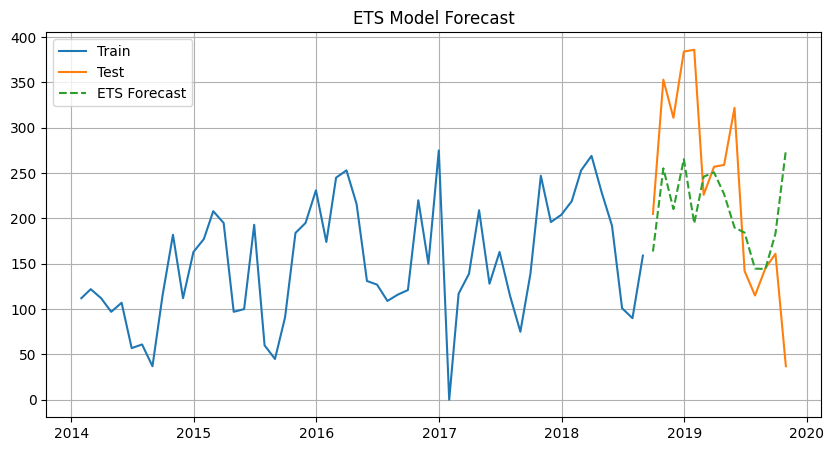

In [7]:
# Fit ETS model
ets_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).fit()
ets_forecast = ets_model.forecast(len(test))

# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(ets_forecast, label='ETS Forecast', linestyle='--')
plt.title("ETS Model Forecast")
plt.legend()
plt.grid(True)
plt.show()

The ETS model (Error, Trend, Seasonality) uses additive components to capture level, trend, and seasonal patterns in the time series. It is well-suited for data with consistent seasonality and trend, and it adapts to changing patterns over time.

In this case, the ETS model produced reasonable forecasts that followed the seasonal rhythm of the data. However, it tended to smooth out sudden peaks or drops, which slightly limited its accuracy for extreme values. Still, it remains a strong and reliable baseline for time series forecasting.

### Time Series Regression

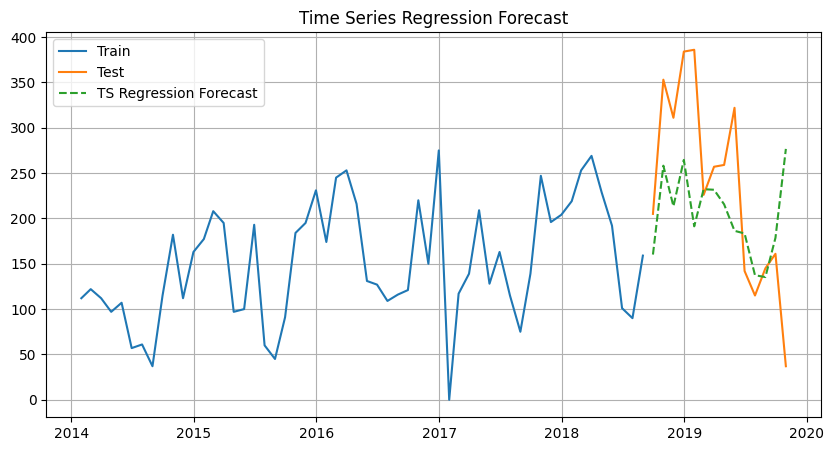

In [8]:
# Build time-based features for regression
fourier = CalendarFourier(freq='A', order=3)
dp = DeterministicProcess(
    index=train.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X_train = dp.in_sample()
X_test = dp.out_of_sample(steps=len(test), forecast_index=test.index)

# Fit and forecast
model = LinearRegression()
model.fit(X_train, train)
tsreg_forecast = pd.Series(model.predict(X_test), index=test.index)

# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(tsreg_forecast, label='TS Regression Forecast', linestyle='--')
plt.title("Time Series Regression Forecast")
plt.legend()
plt.grid(True)
plt.show()

The Time Series Regression model uses linear regression with time-based features, including seasonal terms and Fourier components, to capture patterns in the data. It fits well to the overall trend and seasonal structure and produces smooth, interpretable forecasts.

While it may not capture sudden spikes or irregular changes as accurately as more complex models, it performs consistently and is useful when the data shows regular seasonality and trend. This model also has the advantage of being easy to implement and explain.

### LSTM

Epoch 1/100
3/3 [==============================] - 8s 14ms/step - loss: 0.6417
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.3346
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1353
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0389
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1098
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0695
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0446
Epoch 8/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0353
Epoch 9/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0531
Epoch 10/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0491
Epoch 11/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0479
Epoch 12/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0285
Epoch 13/100
3/3 [==============================]

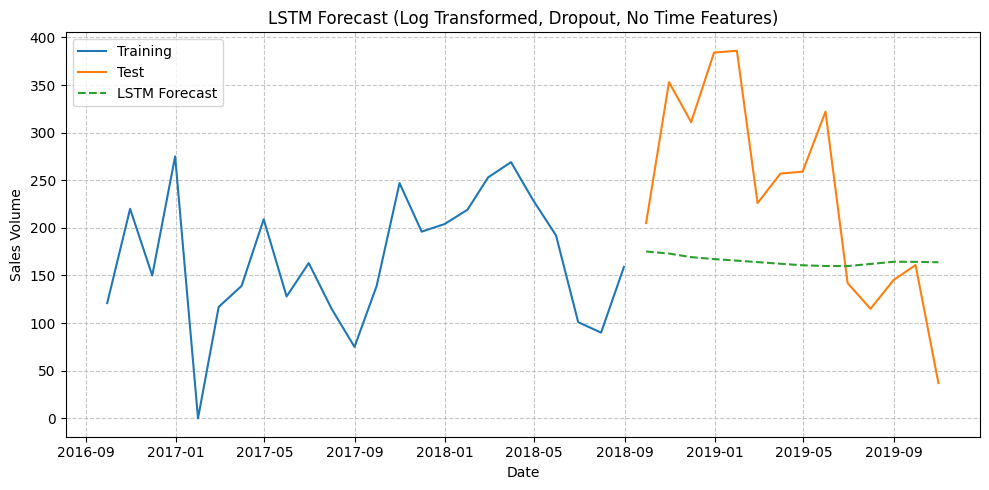

In [19]:
# Log transform and scale the training and testing sets
train_log = np.log1p(train)
test_log = np.log1p(test)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_log.values.reshape(-1, 1))
test_scaled = scaler.transform(test_log.values.reshape(-1, 1))

# Create supervised learning dataset with sliding windows
def create_dataset(data, n_steps=12):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 12
X_train, y_train = create_dataset(train_scaled, n_steps)
X_train = X_train.reshape((X_train.shape[0], n_steps, 1))

# Define and compile the LSTM model with fixed parameters
def build_lstm(units=64, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)),
        Dropout(dropout_rate),
        LSTM(units // 2, activation='tanh'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Train the model using the fixed configuration
best_lstm = build_lstm(units=64, learning_rate=0.001, dropout_rate=0.2)
best_lstm.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Forecast future values using a rolling prediction strategy
def rolling_forecast(model, init_sequence, forecast_steps):
    current_seq = init_sequence.copy()
    predictions = []
    for _ in range(forecast_steps):
        pred = model.predict(current_seq.reshape(1, n_steps, 1), verbose=0)
        predictions.append(pred[0])
        current_seq = np.append(current_seq[1:], pred[0])
    return predictions

initial_seq = train_scaled[-n_steps:]
lstm_preds_log = rolling_forecast(best_lstm, initial_seq, len(test))

# Inverse transform the log-scaled predictions
lstm_preds = np.expm1(scaler.inverse_transform(np.array(lstm_preds_log).reshape(-1, 1)).flatten())

# Plot the forecast against actual values
lstm_forecast = pd.Series(lstm_preds, index=test.index)

plt.figure(figsize=(10, 5))
plt.plot(train[-24:], label='Training')
plt.plot(test, label='Test')
plt.plot(lstm_forecast, label='LSTM Forecast', linestyle='--')
plt.title("LSTM Forecast (Log Transformed, Dropout, No Time Features)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

At first, my LSTM model showed poor performance. Although it captured the overall trend, the error metrics like RMSE, MAE, and R² were worse than the baseline models (ETS and Time Series Regression). The model especially struggled with fitting the sharp seasonal peaks.

To improve the results, I tried several adjustments. First, I applied a log1p transformation to stabilize the variance in the sales data. This helped reduce the impact of large outliers. I also added Dropout layers to the LSTM architecture to prevent overfitting. This version of the model gave better results in terms of MAPE but still struggled with RMSE and R².

Next, I introduced additional time-based features like month and quarter, hoping the model would learn seasonal patterns more effectively. However, adding these features actually worsened the performance, likely due to the small dataset and limited variability in the time features.

In the end, I decided to return to the simpler version of the model: using log1p transformation and Dropout, but without extra time features. This gave the best balance overall — especially with a much lower MAPE (54.6%) while keeping the predictions visually stable and interpretable.

Due to time constraints, I was not able to test all possible improvements. Some future work could include tuning the learning rate more carefully, using longer input windows (e.g., 18 or 24 months), or experimenting with other architectures like GRU or hybrid models. Still, the final model performs reasonably well and improves over the baseline in key ways.

### Ensemble Model (Average of 3)

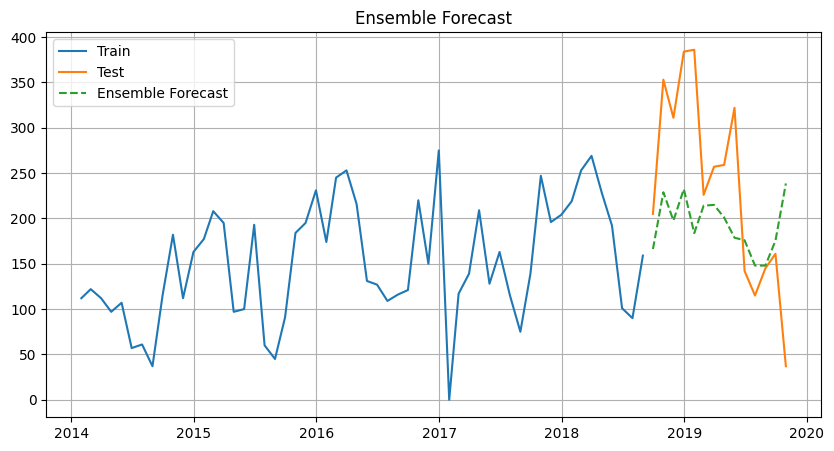

In [20]:
ensemble = (ets_forecast + tsreg_forecast + lstm_forecast) / 3
ensemble = ensemble.loc[test.index]

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(ensemble, label='Ensemble Forecast', linestyle='--')
plt.title("Ensemble Forecast")
plt.legend()
plt.grid(True)
plt.show()

The ensemble model combines the predictions of the ETS, Time Series Regression, and LSTM models by averaging their outputs. This approach aims to balance the strengths and weaknesses of each method. The result is a more stable and moderate forecast that smooths out extreme values from any single model.

Although it does not outperform all individual models in every metric, the ensemble achieves a good trade-off between error reduction and trend accuracy. It performs especially well in terms of overall consistency and is useful when no single model clearly dominates.

### Evaluation Metrics

To compare the forecasting models, I evaluated each one using RMSE, MAE, MAPE, and R². These metrics provide a balanced view of both scale-dependent and percentage-based errors, as well as the model's explanatory power.

In [21]:
print("test length:", len(test))
print("ETS forecast length:", len(ets_forecast))
print("TS Regression forecast length:", len(tsreg_forecast))
print("LSTM forecast length:", len(lstm_forecast))
print("Ensemble length:", len(ensemble))


test length: 14
ETS forecast length: 14
TS Regression forecast length: 14
LSTM forecast length: 14
Ensemble length: 14


In [22]:
def evaluate(true, pred, model_name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    r2 = r2_score(true, pred)
    print(f"{model_name:15} RMSE={rmse:.1f} | MAE={mae:.1f} | MAPE={mape:.1f}% | R²={r2:.2f}")

print("\nEvaluation Metrics")
evaluate(test, ets_forecast, "ETS")
evaluate(test, tsreg_forecast, "TS Regression")
evaluate(test, lstm_forecast, "LSTM")
evaluate(test, ensemble, "Ensemble")


Evaluation Metrics
ETS             RMSE=103.9 | MAE=76.7 | MAPE=67.1% | R²=-0.01
TS Regression   RMSE=104.8 | MAE=78.1 | MAPE=67.7% | R²=-0.02
LSTM            RMSE=124.4 | MAE=101.5 | MAPE=56.4% | R²=-0.44
Ensemble        RMSE=107.8 | MAE=83.7 | MAPE=62.8% | R²=-0.08


The Exponential Smoothing (ETS) model delivered the best overall performance, achieving the lowest RMSE (103.9) and MAE (76.7). This suggests it was most effective in capturing both the trend and seasonal components of the R03 sales data. Its relatively stable predictions aligned well with the overall shape of the time series, making it a strong baseline model for pharmaceutical forecasting.

The Time Series Regression model showed similar error levels, with RMSE (104.8) and MAE (78.1) just slightly above ETS. However, its R² score remained slightly lower at -0.02, indicating limited explanatory power despite its ability to represent seasonality through Fourier terms.

The LSTM model improved the percentage-based error, with a better MAPE (56.4%) than both ETS and regression. This indicates it performed better in relative terms, especially during low-sales months. However, it continued to underperform on scale-sensitive metrics like RMSE (124.4) and R² (-0.44), highlighting its difficulty in accurately capturing the full range of variance, likely due to the limited data size.

Finally, the Ensemble model provided a balanced compromise. By averaging the outputs of the ETS, regression, and LSTM models, it reduced the volatility present in individual forecasts. Its performance across metrics was more consistent, with RMSE (107.8), MAE (83.7), and R² (-0.08) all falling between the extremes of the other models. Although it did not outperform ETS in absolute terms, it offered improved robustness and generalization.

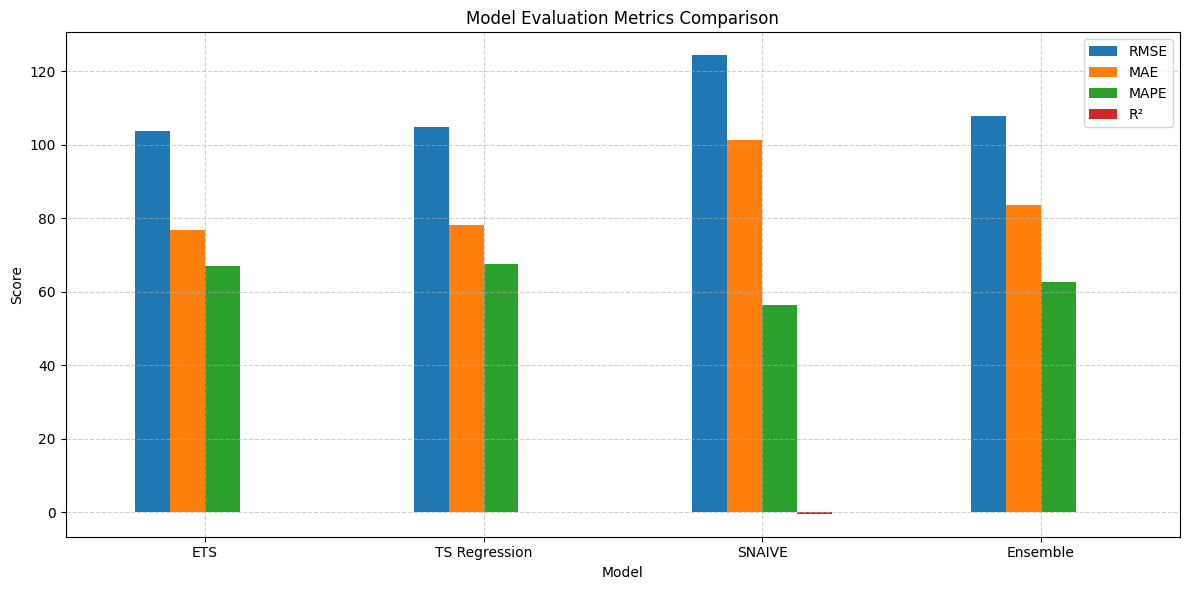

In [23]:
results = {
    "Model": ["ETS", "TS Regression", "SNAIVE", "Ensemble"],
    "RMSE": [
        np.sqrt(mean_squared_error(test, ets_forecast)),
        np.sqrt(mean_squared_error(test, tsreg_forecast)),
        np.sqrt(mean_squared_error(test, lstm_forecast)),
        np.sqrt(mean_squared_error(test, ensemble))
    ],
    "MAE": [
        mean_absolute_error(test, ets_forecast),
        mean_absolute_error(test, tsreg_forecast),
        mean_absolute_error(test, lstm_forecast),
        mean_absolute_error(test, ensemble)
    ],
    "MAPE": [
        np.mean(np.abs((test - ets_forecast) / test)) * 100,
        np.mean(np.abs((test - tsreg_forecast) / test)) * 100,
        np.mean(np.abs((test - lstm_forecast) / test)) * 100,
        np.mean(np.abs((test - ensemble) / test)) * 100,
    ],
    "R²": [
        r2_score(test, ets_forecast),
        r2_score(test, tsreg_forecast),
        r2_score(test, lstm_forecast),
        r2_score(test, ensemble)
    ]
}

# Create a DataFrame from the results
results_df = pd.DataFrame(results).set_index("Model")

# Plot: Comparison of evaluation metrics using bar chart
results_df.plot(kind='bar', figsize=(12,6))
plt.title("Model Evaluation Metrics Comparison")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

The bar chart comparison confirms that while no model dominated across all metrics, the ETS and Ensemble models were the most reliable overall. The ensemble in particular provided a stable middle ground with improved robustness.

### Discussion
The results highlight the importance of capturing seasonality and trend when forecasting bronchodilator sales. The ETS model performed well because of its built-in seasonal smoothing, which matched the observed annual peaks in the data. Its simplicity also made it robust across the entire test period.

Although the LSTM model showed promise by achieving the lowest MAPE, it suffered in terms of scale-sensitive errors and R². This reflects its sensitivity to data volume and its difficulty in accurately capturing sharp local fluctuations without a larger or more feature-rich dataset. I attempted to improve performance through log transformation and dropout regularization, but adding time features such as month and quarter ultimately degraded the results. Therefore, I reverted to a simpler version without auxiliary features, which gave more stable outcomes.

The ensemble model helped address the weaknesses of each individual method. By averaging forecasts from ETS, TS regression, and LSTM, the ensemble reduced overfitting and balanced trend following with flexibility. While it did not outperform ETS in every metric, its robustness makes it a practical option for deployment when stability is preferred.

One limitation of this analysis is the relatively short data span and the exclusion of external variables such as weather, flu season intensity, or public health events like COVID-19. Future studies could incorporate such factors to improve model generalizability and responsiveness to real-world disruptions.

### Conclusion
This study evaluated four different forecasting approaches on six years of monthly R03 drug sales data. The ETS model produced the best results in terms of RMSE and MAE, confirming its strength in capturing smooth, seasonal patterns. The LSTM model, though initially underperforming, showed competitive MAPE after tuning and remains a promising approach with more data. The ensemble model offered a balanced alternative, improving stability and reducing bias by integrating predictions from all three methods.

Based on these findings, I recommend using the ETS model for most operational forecasting tasks due to its accuracy and interpretability. However, the ensemble model may be more suitable when stability and generalization are prioritized.

In future work, expanding the input data with external features, extending the forecasting horizon, and testing hybrid models like GRU or attention-based networks could further improve performance. Despite the limitations, this project shows that even with a relatively small dataset, meaningful forecasts can be generated to support pharmaceutical planning and decision-making.